<a href="https://colab.research.google.com/github/dastias/Projeto-doutorado/blob/main/KDE_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import stft
from sklearn.cluster import MeanShift
from sklearn.datasets import make_blobs
from scipy.fft import fft, ifft, rfft, irfft
from sklearn.cluster import estimate_bandwidth
import pywt
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

Mounted at /content/drive


In [ ]:
dados_normal = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_NOR.csv')

In [ ]:
dados_bea = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_BEA.csv')

In [ ]:
dados_unb = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_UNB.csv')

In [ ]:
dados_mis = pd.read_csv('/content/drive/My Drive/DADOS DOUTORADO/Dados_VBL_MIS.csv')

In [ ]:
def dividir_array_em_partes(array, num_partes):
    tamanho_parte = len(array) // num_partes
    partes = [array[i:i + tamanho_parte] for i in range(0, len(array), tamanho_parte)]
    return partes
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)
def wavelet_denoising(x, wavelet='bior3.9', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')
def expandir_array(row):
    return pd.Series(row[0])

In [ ]:
def calculate_rfft(signal):
    signal = np.ascontiguousarray(signal)
    rfft_sig = rfft(signal)
    rfft_sig_abs = abs(rfft_sig)

    return rfft_sig,rfft_sig_abs

def apply_kde(signal_fft, bandwidth):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(signal_fft[:, None])
    return kde

def grid_search_bandwidth(signal_fft, bandwidth_range):
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidth_range},
                        cv=5)  # 5-fold cross-validation
    grid.fit(signal_fft[:, None])
    return grid.best_params_['bandwidth']

def find_threshold(signal_fft, kde):
    log_density = kde.score_samples(signal_fft[:, None])
    density = np.exp(log_density)
    # Find peaks based on KDE density
    peaks, _ = find_peaks(density)
    return peaks

def filter_signal(signal_fft, peaks):
    filtered_fft = np.zeros_like(signal_fft)
    filtered_fft[peaks] = signal_fft[peaks]
    return filtered_fft

In [ ]:
linha_1 = dados_unb.iloc[0].values
divisao_linha1 = pd.DataFrame(dividir_array_em_partes(linha_1, 124))

In [ ]:
signal=divisao_linha1.iloc[10].values

In [ ]:
fft_signal = rfft(signal)
fft_magnitude = np.abs(fft_signal)
# instantiate and fit the KDE model
bandwidth_range = np.linspace(5, 10, 50)
best_bandwidth = grid_search_bandwidth(fft_magnitude, bandwidth_range)
print(best_bandwidth)

6.224489795918368


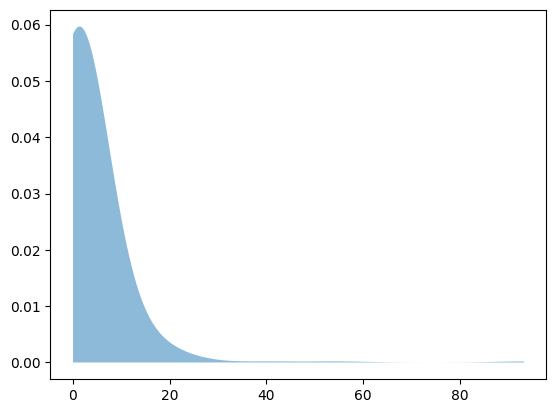

In [ ]:
kde = KernelDensity(bandwidth=6, kernel='gaussian')
kde.fit(fft_magnitude[:, None])
x_d = np.linspace(min(fft_magnitude), max(fft_magnitude), len(fft_magnitude))

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
#plt.plot(fft_magnitude, np.full_like(fft_magnitude, -0.01), '|k', markeredgewidth=1)
#plt.ylim(-0.02, 0.22)

In [ ]:
# Calcular a CDF (função de distribuição acumulada)
cdf = np.exp(logprob).cumsum()
cdf /= cdf[-1]  # normalizar para garantir que vá de 0 a 1

# Encontrar o limiar onde 95% dos valores estão dentro do gráfico
limiar = x_d[np.argmax(cdf >= 0.1)]
print(limiar)

1.0392727126906982


In [ ]:
peak_indices = fft_magnitude > limiar

peak_fft_values = np.zeros_like(fft_signal)
noise_fft_values = np.zeros_like(fft_signal)

peak_fft_values[peak_indices] = fft_signal[peak_indices]
noise_fft_values[~peak_indices] = fft_signal[~peak_indices]

filtered_peak_signal = irfft(peak_fft_values)
filtered_noise_signal = irfft(noise_fft_values)

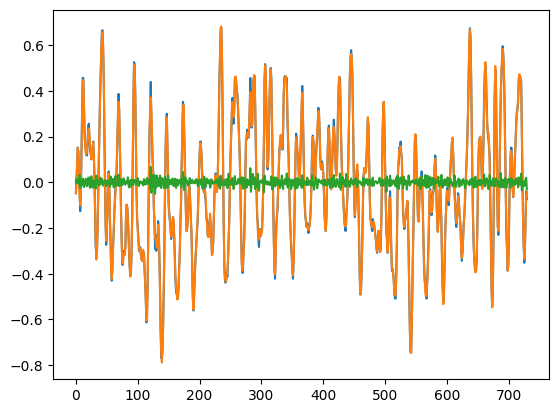

In [ ]:
plt.plot(signal)
plt.plot(filtered_peak_signal)
plt.plot(filtered_noise_signal)

In [ ]:
def denoising_KDE_nor(signal):
  signal = np.ascontiguousarray(signal)
  fft_signal = rfft(signal)
  fft_magnitude = np.abs(fft_signal)

  kde = KernelDensity(bandwidth=1.5, kernel='gaussian')
  kde.fit(fft_magnitude[:, None])
  x_d = np.linspace(min(fft_magnitude), max(fft_magnitude), len(fft_magnitude))


  logprob = kde.score_samples(x_d[:, None])

  cdf = np.exp(logprob).cumsum()
  cdf /= cdf[-1]

  limiar = x_d[np.argmax(cdf >= 0.1)]

  peak_indices = fft_magnitude > limiar

  peak_fft_values = np.zeros_like(fft_signal)
  noise_fft_values = np.zeros_like(fft_signal)

  peak_fft_values[peak_indices] = fft_signal[peak_indices]
  noise_fft_values[~peak_indices] = fft_signal[~peak_indices]

  filtered_peak_signal = irfft(peak_fft_values)
  filtered_noise_signal = irfft(noise_fft_values)

  return filtered_peak_signal

In [ ]:
def denoising_KDE_bea(signal):
  signal = np.ascontiguousarray(signal)
  fft_signal = rfft(signal)
  fft_magnitude = np.abs(fft_signal)

  kde = KernelDensity(bandwidth=20, kernel='gaussian')
  kde.fit(fft_magnitude[:, None])
  x_d = np.linspace(min(fft_magnitude), max(fft_magnitude), len(fft_magnitude))


  logprob = kde.score_samples(x_d[:, None])

  cdf = np.exp(logprob).cumsum()
  cdf /= cdf[-1]

  limiar = x_d[np.argmax(cdf >= 0.1)]

  peak_indices = fft_magnitude > limiar

  peak_fft_values = np.zeros_like(fft_signal)
  noise_fft_values = np.zeros_like(fft_signal)

  peak_fft_values[peak_indices] = fft_signal[peak_indices]
  noise_fft_values[~peak_indices] = fft_signal[~peak_indices]

  filtered_peak_signal = irfft(peak_fft_values)
  filtered_noise_signal = irfft(noise_fft_values)

  return filtered_peak_signal

In [ ]:
def denoising_KDE_mis(signal):
  signal = np.ascontiguousarray(signal)
  fft_signal = rfft(signal)
  fft_magnitude = np.abs(fft_signal)

  kde = KernelDensity(bandwidth=25, kernel='gaussian')
  kde.fit(fft_magnitude[:, None])
  x_d = np.linspace(min(fft_magnitude), max(fft_magnitude), len(fft_magnitude))


  logprob = kde.score_samples(x_d[:, None])

  cdf = np.exp(logprob).cumsum()
  cdf /= cdf[-1]

  limiar = x_d[np.argmax(cdf >= 0.1)]

  peak_indices = fft_magnitude > limiar

  peak_fft_values = np.zeros_like(fft_signal)
  noise_fft_values = np.zeros_like(fft_signal)

  peak_fft_values[peak_indices] = fft_signal[peak_indices]
  noise_fft_values[~peak_indices] = fft_signal[~peak_indices]

  filtered_peak_signal = irfft(peak_fft_values)
  filtered_noise_signal = irfft(noise_fft_values)

  return filtered_peak_signal

In [ ]:
def denoising_KDE_unb(signal):
  signal = np.ascontiguousarray(signal)
  fft_signal = rfft(signal)
  fft_magnitude = np.abs(fft_signal)

  kde = KernelDensity(bandwidth=6, kernel='gaussian')
  kde.fit(fft_magnitude[:, None])
  x_d = np.linspace(min(fft_magnitude), max(fft_magnitude), len(fft_magnitude))


  logprob = kde.score_samples(x_d[:, None])

  cdf = np.exp(logprob).cumsum()
  cdf /= cdf[-1]

  limiar = x_d[np.argmax(cdf >= 0.1)]

  peak_indices = fft_magnitude > limiar

  peak_fft_values = np.zeros_like(fft_signal)
  noise_fft_values = np.zeros_like(fft_signal)

  peak_fft_values[peak_indices] = fft_signal[peak_indices]
  noise_fft_values[~peak_indices] = fft_signal[~peak_indices]

  filtered_peak_signal = irfft(peak_fft_values)
  filtered_noise_signal = irfft(noise_fft_values)

  return filtered_peak_signal

In [ ]:
normal_filtrado_KDE_125 = pd.DataFrame()
#filtered_data = []
for i in range(100):
  arranjo = dados_normal.iloc[i].values
  divisao = dividir_array_em_partes(arranjo,124)
  divisao_df = pd.DataFrame(divisao)
  divisao_df_drop = divisao_df.drop(divisao_df.index[-1])
  divisao_filtrada = divisao_df_drop.apply(denoising_KDE_nor,axis=1)
  divisao_filtrada_df = pd.DataFrame(divisao_filtrada)
  matriz_expandida = divisao_filtrada_df.apply(expandir_array, axis=1)

  df_transformado = pd.DataFrame((matriz_expandida.values.flatten()).T).T
  normal_filtrado_KDE_125 = pd.concat([normal_filtrado_KDE_125,df_transformado])

In [ ]:
bea_filtrado_KDE_125 = pd.DataFrame()
#filtered_data = []
for i in range(100):
  arranjo = dados_bea.iloc[i].values
  divisao = dividir_array_em_partes(arranjo,124)
  divisao_df = pd.DataFrame(divisao)
  divisao_df_drop = divisao_df.drop(divisao_df.index[-1])
  divisao_filtrada = divisao_df_drop.apply(denoising_KDE_bea,axis=1)
  divisao_filtrada_df = pd.DataFrame(divisao_filtrada)
  matriz_expandida = divisao_filtrada_df.apply(expandir_array, axis=1)

  df_transformado = pd.DataFrame((matriz_expandida.values.flatten()).T).T
  bea_filtrado_KDE_125 = pd.concat([bea_filtrado_KDE_125,df_transformado])

In [ ]:
mis_filtrado_KDE_125 = pd.DataFrame()
#filtered_data = []
for i in range(100):
  arranjo = dados_mis.iloc[i].values
  divisao = dividir_array_em_partes(arranjo,124)
  divisao_df = pd.DataFrame(divisao)
  divisao_df_drop = divisao_df.drop(divisao_df.index[-1])
  divisao_filtrada = divisao_df_drop.apply(denoising_KDE_mis,axis=1)
  divisao_filtrada_df = pd.DataFrame(divisao_filtrada)
  matriz_expandida = divisao_filtrada_df.apply(expandir_array, axis=1)

  df_transformado = pd.DataFrame((matriz_expandida.values.flatten()).T).T
  mis_filtrado_KDE_125 = pd.concat([mis_filtrado_KDE_125,df_transformado])

In [ ]:
unb_filtrado_KDE_125 = pd.DataFrame()
#filtered_data = []
for i in range(100):
  arranjo = dados_unb.iloc[i].values
  divisao = dividir_array_em_partes(arranjo,124)
  divisao_df = pd.DataFrame(divisao)
  divisao_df_drop = divisao_df.drop(divisao_df.index[-1])
  divisao_filtrada = divisao_df_drop.apply(denoising_KDE_unb,axis=1)
  divisao_filtrada_df = pd.DataFrame(divisao_filtrada)
  matriz_expandida = divisao_filtrada_df.apply(expandir_array, axis=1)

  df_transformado = pd.DataFrame((matriz_expandida.values.flatten()).T).T
  unb_filtrado_KDE_125 = pd.concat([unb_filtrado_KDE_125,df_transformado])

In [ ]:
'''
normal_filtrado_KDE_125.to_csv('/content/drive/My Drive/DADOS DOUTORADO/KDE_Filter/normal_filtrado_KDE_125.csv', index=False)
bea_filtrado_KDE_125.to_csv('/content/drive/My Drive/DADOS DOUTORADO/KDE_Filter/bea_filtrado_KDE_125.csv', index=False)
mis_filtrado_KDE_125.to_csv('/content/drive/My Drive/DADOS DOUTORADO/KDE_Filter/mis_filtrado_KDE_125.csv', index=False)
unb_filtrado_KDE_125.to_csv('/content/drive/My Drive/DADOS DOUTORADO/KDE_Filter/unb_filtrado_KDE_125.csv', index=False)
'''

In [ ]:
def FFT(data):
    '''FFT process and filtering'''
    data = np.asarray(data)
    fft = abs(rfft(data))
    return fft

def mean(data):
    '''Mean features'''
    data = np.asarray(data)
    M = pd.DataFrame(np.mean(data, axis=1))
    return M

def pp(data):
    '''Peak-to-Peak features'''
    data = np.asarray(data)
    PP = pd.DataFrame(np.max(data, axis=1) - np.min(data, axis=1))
    return PP

def rms(data):
    '''RMS features'''
    data = np.asarray(data)
    Rms = pd.DataFrame(np.sqrt(np.mean(data**2, axis=1)))
    return Rms

In [ ]:
fft_normal_KDE = pd.DataFrame(FFT(normal_filtrado_KDE_125.iloc[:100]))
fft_bea_KDE = pd.DataFrame(FFT(bea_filtrado_KDE_125.iloc[:100]))
fft_mis_KDE = pd.DataFrame(FFT(mis_filtrado_KDE_125.iloc[:100]))
fft_unb_KDE = pd.DataFrame(FFT(unb_filtrado_KDE_125.iloc[:100]))

data_merged_KDE = pd.concat((fft_normal_KDE, fft_bea_KDE,fft_mis_KDE,fft_unb_KDE))

def NormalizeDataKDE(data):  # Normalisasi (0-1)
    data_max = np.max(data_merged_KDE)
    data_min = np.min(data_merged_KDE)
    return pd.DataFrame((data - np.min(data_min)) / (np.max(data_max) - np.min(data_min)))

fft_normal_norm_KDE = NormalizeDataKDE(fft_normal_KDE)
fft_bea_norm_KDE = NormalizeDataKDE(fft_bea_KDE)
fft_mis_norm_KDE = NormalizeDataKDE(fft_mis_KDE)
fft_unb_norm_KDE = NormalizeDataKDE(fft_unb_KDE)


media_normal_KDE = mean(fft_normal_norm_KDE)
media_bea_KDE = mean(fft_bea_norm_KDE)
media_mis_KDE = mean(fft_mis_norm_KDE)
media_unb_KDE = mean(fft_unb_norm_KDE)

pp_normal_KDE = pp(fft_normal_norm_KDE)
pp_bea_KDE = pp(fft_bea_norm_KDE)
pp_mis_KDE = pp(fft_mis_norm_KDE)
pp_unb_KDE = pp(fft_unb_norm_KDE)

rms_normal_KDE = rms(fft_normal_norm_KDE)
rms_bea_KDE = rms(fft_bea_norm_KDE)
rms_mis_KDE = rms(fft_mis_norm_KDE)
rms_unb_KDE = rms(fft_unb_norm_KDE)

feat_normal_KDE = pd.concat((media_normal_KDE, pp_normal_KDE, rms_normal_KDE), axis=1)
feat_bea_KDE = pd.concat((media_bea_KDE, pp_bea_KDE, rms_bea_KDE), axis=1)
feat_mis_KDE = pd.concat((media_mis_KDE, pp_mis_KDE, rms_mis_KDE), axis=1)
feat_unb_KDE = pd.concat((media_unb_KDE, pp_unb_KDE, rms_unb_KDE), axis=1)

feat_normal_KDE.columns = ['media', 'pp', 'rms']
feat_bea_KDE.columns = ['media', 'pp', 'rms']
feat_mis_KDE.columns = ['media', 'pp', 'rms']
feat_unb_KDE.columns = ['media', 'pp', 'rms']

feat_normal_KDE['cond']=0
feat_bea_KDE['cond']=1
feat_mis_KDE['cond']=2
feat_unb_KDE['cond']=3

matriz_classificacao_KDE = pd.concat((feat_normal_KDE, feat_bea_KDE, feat_mis_KDE, feat_unb_KDE))



In [ ]:
X_KDE = matriz_classificacao_KDE.drop('cond', axis=1)
y_KDE = matriz_classificacao_KDE['cond']

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Dividindo em conjunto de treino e teste
X_train_KDE, X_test_KDE, y_train_KDE, y_test_KDE = train_test_split(X_KDE, y_KDE, test_size=0.2, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train_KDE = scaler.fit_transform(X_train_KDE)
X_test_KDE = scaler.transform(X_test_KDE)

y_train_KDE = tf.keras.utils.to_categorical(y_train_KDE, num_classes=4)
y_test_KDE = tf.keras.utils.to_categorical(y_test_KDE, num_classes=4)

# Construindo o modelo
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))  # Primeira camada oculta com 12 neurônios
model.add(Dense(16, activation='relu'))                # Segunda camada oculta com 8 neurônios
model.add(Dense(4, activation='softmax'))             # Camada de saída com 1 neurônio e ativação sigmoid para classificação binária

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history=model.fit(X_train_KDE, y_train_KDE, epochs=50, batch_size=10, validation_data=(X_test_KDE, y_test_KDE))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test_KDE, y_test_KDE)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


Epoch 1/50
32/32 [==============================] - 1s 10ms/step - loss: 1.1936 - accuracy: 0.6781 - val_loss: 1.0470 - val_accuracy: 0.7875
Epoch 2/50
32/32 [==============================] - 0s 3ms/step - loss: 0.9807 - accuracy: 0.7469 - val_loss: 0.8469 - val_accuracy: 0.7625
Epoch 3/50
32/32 [==============================] - 0s 3ms/step - loss: 0.8005 - accuracy: 0.7219 - val_loss: 0.6902 - val_accuracy: 0.8250
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6466 - accuracy: 0.7937 - val_loss: 0.5656 - val_accuracy: 0.8625
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.5322 - accuracy: 0.8781 - val_loss: 0.4828 - val_accuracy: 0.8625
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.4509 - accuracy: 0.8750 - val_loss: 0.4226 - val_accuracy: 0.8875
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 0.3937 - accuracy: 0.9000 - val_loss: 0.3862 - val_accuracy: 0.8875
Epoch 8/50
32/32 [=

3/3 [==============================] - 0s 5ms/step
Acurácia: 0.94
Relatório de classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        18
           2       0.78      1.00      0.88        18
           3       1.00      0.72      0.84        18

    accuracy                           0.94        80
   macro avg       0.95      0.93      0.93        80
weighted avg       0.95      0.94      0.94        80

Matriz de confusão:
[[26  0  0  0]
 [ 0 18  0  0]
 [ 0  0 18  0]
 [ 0  0  5 13]]


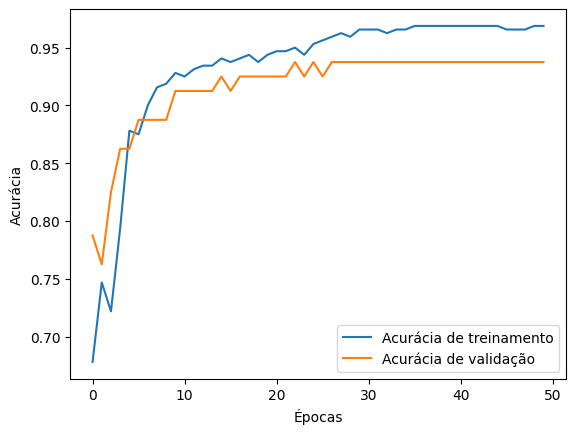

In [ ]:
# Fazer previsões com o conjunto de teste
y_pred_ANN_KDE = model.predict(X_test_KDE)
y_pred_classes_ANN_KDE = np.argmax(y_pred_ANN_KDE, axis=1)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(np.argmax(y_test_KDE, axis=1), y_pred_classes_ANN_KDE)
print(f"Acurácia: {accuracy:.2f}")

# Mostrar relatório de classificação
print("Relatório de classificação:")
print(classification_report(np.argmax(y_test_KDE, axis=1), y_pred_classes_ANN_KDE))

# Mostrar matriz de confusão
print("Matriz de confusão:")
print(confusion_matrix(np.argmax(y_test_KDE, axis=1), y_pred_classes_ANN_KDE))

# Exibir o histórico de treinamento
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Acurácia de treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_KDE, y_KDE, test_size=0.2, random_state=0)

SVM Classification Score is: 0.875


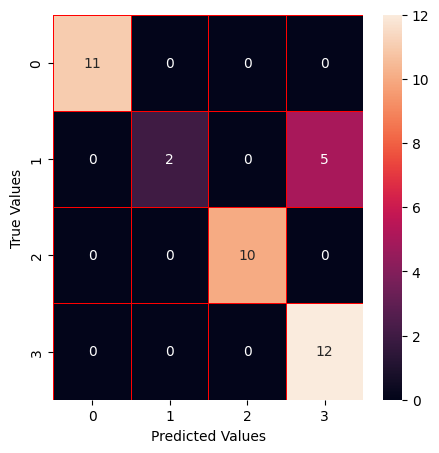

In [ ]:
import seaborn as sns
method_names = []
method_scores = []
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(x_train,y_train)
print("SVM Classification Score is: {}".format(svm.score(x_test,y_test)))
method_names.append("SVM")
method_scores.append(svm.score(x_test,y_test))

#Confusion Matrix
y_pred = svm.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
#Visualization Confusion Matrix
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

Text(0, 0.5, 'score')

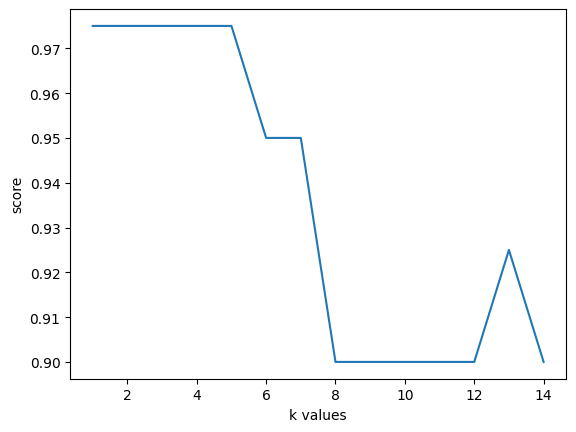

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
score_list=[]
for each in range(1,15):
   knn2 = KNeighborsClassifier(n_neighbors=each)
   knn2.fit(x_train,y_train)
   score_list.append(knn2.score(x_test,y_test))
plt.plot(range(1,15),score_list)
plt.xlabel("k values")
plt.ylabel("score")

Score for Number of Neighbors = 4: 0.975


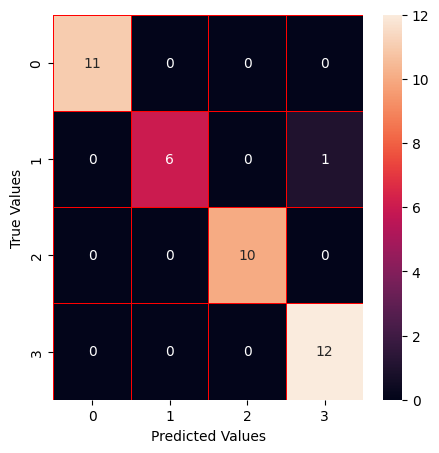

In [ ]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train,y_train)
print("Score for Number of Neighbors = 4: {}".format(knn.score(x_test,y_test)))

y_pred = knn.predict(x_test)
conf_mat = confusion_matrix(y_test,y_pred)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

In [ ]:
fft_normal = pd.DataFrame(FFT(dados_normal.iloc[:100]))
fft_bea = pd.DataFrame(FFT(dados_bea.iloc[:100]))
fft_mis = pd.DataFrame(FFT(dados_mis.iloc[:100]))
fft_unb = pd.DataFrame(FFT(dados_unb.iloc[:100]))

data_merged = pd.concat((fft_normal, fft_bea,fft_mis,fft_unb))

def NormalizeData(data):  # Normalisasi (0-1)
    data_max = np.max(data_merged)
    data_min = np.min(data_merged)
    return pd.DataFrame((data - np.min(data_min)) / (np.max(data_max) - np.min(data_min)))

fft_normal_norm = NormalizeData(fft_normal)
fft_bea_norm = NormalizeData(fft_bea)
fft_mis_norm = NormalizeData(fft_mis)
fft_unb_norm = NormalizeData(fft_unb)

media_normal = mean(fft_normal_norm)
media_bea = mean(fft_bea_norm)
media_mis = mean(fft_mis_norm)
media_unb = mean(fft_unb_norm)
pp_normal = pp(fft_normal_norm)
pp_bea = pp(fft_bea_norm)
pp_mis = pp(fft_mis_norm)
pp_unb = pp(fft_unb_norm)
rms_normal = rms(fft_normal_norm)
rms_bea = rms(fft_bea_norm)
rms_mis = rms(fft_mis_norm)
rms_unb = rms(fft_unb_norm)

feat_normal = pd.concat((media_normal, pp_normal, rms_normal), axis=1)
feat_bea = pd.concat((media_bea, pp_bea, rms_bea), axis=1)
feat_mis = pd.concat((media_mis, pp_mis, rms_mis), axis=1)
feat_unb = pd.concat((media_unb, pp_unb, rms_unb), axis=1)

feat_normal.columns = ['media', 'pp', 'rms']
feat_bea.columns = ['media', 'pp', 'rms']
feat_mis.columns = ['media', 'pp', 'rms']
feat_unb.columns = ['media', 'pp', 'rms']

feat_normal['cond']=0
feat_bea['cond']=1
feat_mis['cond']=2
feat_unb['cond']=3

matriz_classificacao = pd.concat((feat_normal, feat_bea, feat_mis, feat_unb))

X = matriz_classificacao.drop('cond', axis=1)
y = matriz_classificacao['cond']

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# Dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Padronizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Construindo o modelo
model = Sequential()
model.add(Dense(32, input_dim=3, activation='relu'))  # Primeira camada oculta com 12 neurônios
model.add(Dense(16, activation='relu'))                # Segunda camada oculta com 8 neurônios
model.add(Dense(4, activation='softmax'))             # Camada de saída com 1 neurônio e ativação sigmoid para classificação binária

# Compilando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history=model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/50
32/32 [==============================] - 1s 11ms/step - loss: 1.2175 - accuracy: 0.6219 - val_loss: 1.0508 - val_accuracy: 0.7500
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.9977 - accuracy: 0.7094 - val_loss: 0.8492 - val_accuracy: 0.7500
Epoch 3/50
32/32 [==============================] - 0s 4ms/step - loss: 0.8304 - accuracy: 0.7156 - val_loss: 0.7114 - val_accuracy: 0.7625
Epoch 4/50
32/32 [==============================] - 0s 4ms/step - loss: 0.7027 - accuracy: 0.7156 - val_loss: 0.6267 - val_accuracy: 0.7625
Epoch 5/50
32/32 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.7250 - val_loss: 0.5412 - val_accuracy: 0.7750
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.5246 - accuracy: 0.7594 - val_loss: 0.4832 - val_accuracy: 0.8250
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4608 - accuracy: 0.8531 - val_loss: 0.4283 - val_accuracy: 0.8875
Epoch 8/50
32/32 [=

In [ ]:
normal_100 = dados_normal.iloc[:100]
bea_100 = dados_bea.iloc[:100]
mis_100 = dados_mis.iloc[:100]
unb_100 = dados_unb.iloc[:100]

normal_100.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Conjunto de Dados para Avaliação (Padrão, KDE, Padrao_wave, KDE_wave)/normal_100.csv', index=False)
bea_100.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Conjunto de Dados para Avaliação (Padrão, KDE, Padrao_wave, KDE_wave)/bea_100.csv', index=False)
mis_100.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Conjunto de Dados para Avaliação (Padrão, KDE, Padrao_wave, KDE_wave)/mis_100.csv', index=False)
unb_100.to_csv('/content/drive/My Drive/DADOS DOUTORADO/Conjunto de Dados para Avaliação (Padrão, KDE, Padrao_wave, KDE_wave)/unb_100.csv', index=False)